# Siamese Convolutional Neural Network<br>(Triplet Loss)

In [1]:
from preprocess import SiameseTriplets
from triplet_utils import *

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pickle
import time
from datetime import datetime, timedelta
import numpy as np
from pandas import DataFrame

import tensorflow as tf
import keras.backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, roc_auc_score
import wandb

# plotting
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if not os.path.exists('./weights'):
    os.makedirs('./weights')
    print("Weights directory created")
else:
    print("Weights directory exists")

Weights directory created


## Setting up datasets

In [3]:
def data_shapes(data):
    print("\nNumber of classes   : ", data.train_images.shape[0])
    print("Original signatures : ", len(data.train_images[0][0]))
    print("Forged signatures   : ", len(data.train_images[0][1]))
    print("Image shape         : ", data.train_images[0][0][0].shape)
    print()

In [4]:
def plot_triplets(data):
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8,8))

    ax[0].imshow(data.triplets[0][0])
    ax[1].imshow(data.triplets[1][0])
    ax[2].imshow(data.triplets[2][0])
    # subplot titles
    ax[0].set_title('Anchor')
    ax[1].set_title('Positive')
    ax[2].set_title('Negative')

    fig.tight_layout()
    plt.show()

In [5]:
def model_training(model, weights_name):
    print("\nStarting training!\n")

    # hyperparameters
    EPOCHS = 100  # number of epochs
    BS = 128  # batch size

    # callbacks
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1,)]

    history = model.fit(
        pairs, targets,
        batch_size=BS,
        epochs=EPOCHS,
        verbose=1,
        callbacks=callbacks,
        validation_split=0.3,
    )

    ALL_HISTORY.append(history)

    print("\nSaving weight for model...", end="")
    siamese_contrastive.save_weights('./weights/{0}.h5'.format(weights_name))
    print("saved successfully!")

## Everything put together

In [6]:
DATA_PATH = "../input/handwritten-signature-datasets/CEDAR/CEDAR"  # path to dataset (kaggle)
SAVE_PATH = "./"                                                   # path to save pickle files (kaggle)

# DATA_PATH = "data\\CEDAR"             # path to dataset
# SAVE_PATH = "data\\pickle-files"      # path to save pickle files

CLASSES = len(os.listdir(DATA_PATH))  # number of classes
NAME = "CEDAR"

# size of images
SIZE = 224
CHANNELS = 1
INPUT_SHAPE = (SIZE, SIZE, CHANNELS)

# evaluation
ALL_HISTORY = []
ACCURACIES = []
THRESHOLDS = []
PLOTS = []

TO_RESET = False

In [7]:
IS_TPU = True

if IS_TPU:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

    # instantiate a distribution strategy
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [8]:
# loading dataset
dataset = SiameseTriplets(name=NAME,
                          data_path=DATA_PATH,
                          save_path=SAVE_PATH,
                          channels=CHANNELS,
                          size=SIZE,
                          reset=TO_RESET)

LOADING TRIPLETS:  22%|██▏       | 145/660 [00:00<00:00, 1445.52it/s]


Pickle file saved!



LOADING TRIPLETS: 100%|██████████| 660/660 [00:00<00:00, 1442.36it/s]



Pickle file saved!




Number of classes   :  55
Original signatures :  24
Forged signatures   :  24
Image shape         :  (224, 224, 1)



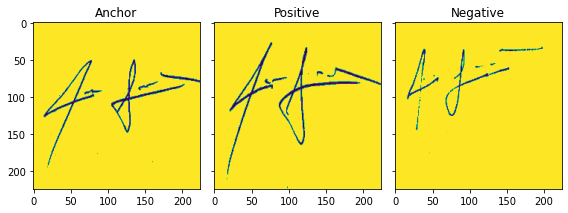

In [9]:
data_shapes(dataset)    # seeing dataset
plot_triplets(dataset)  # plotting dataset

In [10]:
# Hyper parameters
alpha1 = 1
alpha2 = 0.5
embeddingsize = 10
nb_test_class = 10

evaluate_every = 1000 # interval for evaluating on one-shot tasks
n_iter = 10000        # No. of training iterations
log_every = 50
sample_batch_size = 16

optimizer = Adam(lr = 0.00006)

In [11]:
projectName = "CEDAR_triplet_loss"

# wandb config
wandb.init(project=projectName)
wandb.config.alpha1 = alpha1
wandb.config.alpha2 = alpha2
wandb.config.sample_batch_size = sample_batch_size
wandb.config.learningrate = K.eval(optimizer.lr) 

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
with tpu_strategy.scope():
    # defining the embedding and network
    embedding = embedding_net(embeddingsize, INPUT_SHAPE)
    siamese_network3 = build_triplet_model(INPUT_SHAPE, embedding, margin=1)

    siamese_network3.compile(loss=None,optimizer=optimizer)

    siamese_network3.summary()
    plot_model(siamese_network3, show_shapes=True, show_layer_names=True, to_file='TRIPLETmodel.png')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_network (Sequential) (None, 10)           411685322   anchor_input[0][0]               
                                                                 positive_input[0][0]         

In [13]:
n_iteration = 0
print("Starting training process!")
print("-------------------------------------")

t_start = time.time()
for i in range(1, n_iter+1):
    microtask_start = time.time()
    triplets = dataset.generate_triplets(16)
    timetogetbatch = time.time()-microtask_start

    microtask_start = time.time()
    loss = siamese_network3.train_on_batch(triplets, None)
    timebatch3 = time.time()-microtask_start

    microtask_start = time.time()

    n_iteration += 1

    if i % log_every == 0:
        wandb.log({'loss3x': loss}, step=n_iteration)

    if i % evaluate_every == 0:
        elapsed_minutes = (time.time()-t_start)/60.0
        rate = i/elapsed_minutes
        eta = datetime.now() + timedelta(minutes=(n_iter-i)/rate)
        eta = eta + timedelta(hours=0) #french time

        print("[{3}] iteration {0}: {1:.1f} iter/min, Train Loss: {2} , eta : {4}".format(
            i, rate, loss, n_iteration, eta.strftime("%Y-%m-%d %H:%M:%S")
        ))

        siamese_network3.save_weights('./weights/3x-temp_weights_{0:08d}.h5'.format(n_iteration))

# Final save
siamese_network3.save_weights('./weights/3x-temp_weights_{0:08d}.h5'.format(n_iteration))
print("Done !")

Starting training process!
-------------------------------------
[1000] iteration 1000: 76.5 iter/min, Train Loss: 0.32777124643325806 , eta : 2021-07-14 15:08:23
[2000] iteration 2000: 76.8 iter/min, Train Loss: 0.254496693611145 , eta : 2021-07-14 15:07:53
[3000] iteration 3000: 77.5 iter/min, Train Loss: 0.3297528028488159 , eta : 2021-07-14 15:06:47
[4000] iteration 4000: 77.5 iter/min, Train Loss: 0.1944582313299179 , eta : 2021-07-14 15:06:44
[5000] iteration 5000: 77.6 iter/min, Train Loss: 0.1924532800912857 , eta : 2021-07-14 15:06:33
[6000] iteration 6000: 77.8 iter/min, Train Loss: 0.15667487680912018 , eta : 2021-07-14 15:06:18
[7000] iteration 7000: 77.6 iter/min, Train Loss: 0.15910491347312927 , eta : 2021-07-14 15:06:31
[8000] iteration 8000: 77.7 iter/min, Train Loss: 0.2561168372631073 , eta : 2021-07-14 15:06:27
[9000] iteration 9000: 77.7 iter/min, Train Loss: 0.34664106369018555 , eta : 2021-07-14 15:06:27
[10000] iteration 10000: 77.8 iter/min, Train Loss: 0.12912

In [29]:
!zip -r './weights.zip' './weights/3x-temp_weights_00010000.h5'

  adding: weights/3x-temp_weights_00010000.h5 (deflated 7%)


In [28]:
os.listdir('./weights')

['3x-temp_weights_00008000.h5',
 '3x-temp_weights_00010000.h5',
 '3x-temp_weights_00001000.h5',
 '3x-temp_weights_00003000.h5',
 '3x-temp_weights_00005000.h5',
 '3x-temp_weights_00002000.h5',
 '3x-temp_weights_00007000.h5',
 '3x-temp_weights_00009000.h5',
 '3x-temp_weights_00006000.h5',
 '3x-temp_weights_00004000.h5']